## Project IMPACT Covid Cases by Zip Code in Chicago 5/13/2020

### Purpose is to develop an infographic from the data that will show specific Chicago areas where Covid cases are recorded

#### https://data.cityofchicago.org/Health-Human-Services/COVID-19-Cases-Tests-and-Deaths-by-ZIP-Code/yhhz-zm2v

#### Each row is a Week of COVID-19 Metrics for a ZIP Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import calendar
import datetime
import seaborn as sns
from osgeo import gdal, ogr, osr
from fiona.ogrext import Iterator, ItemsIterator, KeysIterator
import geopandas as gpd
from geopandas import GeoDataFrame
import descartes
from shapely.geometry import Point, Polygon

In [3]:
#Get the map file from the Chicago Data Portal
zip_map = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=Shapefile')

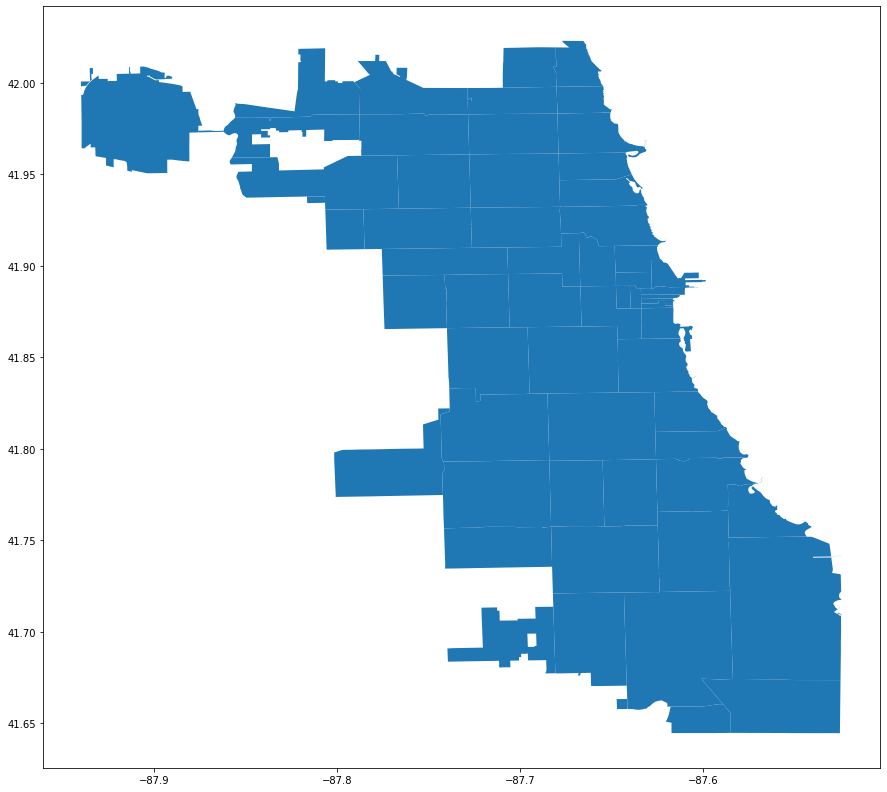

In [4]:
#Import the map, call it zip_map
fig, ax = plt.subplots(figsize = (15,15))
zip_map.plot(ax=ax)

In [5]:
#Get the dataset https://data.cityofchicago.org/Health-Human-Services/COVID-19-Cases-Tests-and-Deaths-by-ZIP-Code/yhhz-zm2v as of 5/13/20
covid = pd.read_csv(('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code-5-13-20.csv'))

In [6]:
covid.head() #All the blanks in the csv file are NaN here and need to be filled in.
#Note that ZIP Code Location with POINT, Longitude, Latitude has already been done which will save time on geometry later

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,NaN,NaN,NaN,NaN,0,0,...,0,NaN,NaN,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)
1,60621,11,3/8/2020,3/14/2020,NaN,NaN,NaN,NaN,3,3,...,8.4,NaN,NaN,0,0,0.0,0.0,"35,912",60621-11,POINT (-87.638812 41.776931)
2,60626,11,3/8/2020,3/14/2020,NaN,NaN,NaN,NaN,5,6,...,12,NaN,NaN,0,0,0.0,0.0,"50,139",60626-11,POINT (-87.669834 42.009469)
3,60606,19,5/3/2020,5/9/2020,7.0,36,303.0,"1,559.80",48,228,...,"9,878.70",0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634)
4,60638,15,4/5/2020,4/11/2020,81.0,148,147.0,269,232,648,...,"1,177.60",0.3,0.2,2,3,3.6,5.5,"55,026",60638-15,POINT (-87.771902 41.787032)


In [7]:
#The missing values are due to data not available until there are >=5 cases, so replace the blanks with 0
covid.replace(np.nan, 0, inplace = True)

In [8]:
covid.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,0.0,0,0.0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)


In [9]:
covid.dtypes

ZIP Code                                 object
Week Number                               int64
Week Start                               object
Week End                                 object
Cases - Weekly                          float64
Cases - Cumulative                       object
Case Rate - Weekly                      float64
Case Rate - Cumulative                   object
Tests - Weekly                           object
Tests - Cumulative                       object
Test Rate - Weekly                       object
Test Rate - Cumulative                   object
Percent Tested Positive - Weekly        float64
Percent Tested Positive - Cumulative    float64
Deaths - Weekly                           int64
Deaths - Cumulative                       int64
Death Rate - Weekly                     float64
Death Rate - Cumulative                 float64
Population                               object
Row ID                                   object
ZIP Code Location                       

## The focus is on Cases - Weekly and Cases - Cumulative along a zip code and specific week

In [10]:
#Convert the Cases - Weekly and Cases - Cumulative from float to integer format
covid["Cases - Weekly"] = covid["Cases - Weekly"].astype(int)
#No issue with this



### The mistake from coaching was to replace the comma with a period, therefore when I converted to float and then integer, I lost all values >=1,000, as they became 1 or 2!!

### First I need to eliminate the commas from values such as 1,007.  Then I need to replace that new space with no space so the value becomes 1007.  Then I can convert it to float and finally an integer

In [44]:
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].fillna(0)
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].str.replace(",","")
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].str.replace(" ","")
#covid["Cases - Cumulative"] = covid["Cases - Cumulative"].astype("float")
#From Thinkful technical coaching
#You were getting the error because the decimal separator in that field is comma (,). Use the following code:


In [45]:
covid["Cases - Cumulative"]
    

0      NaN
1      NaN
2      NaN
3       36
4      148
      ... 
595    232
596     71
597     67
598      9
599    NaN
Name: Cases - Cumulative, Length: 600, dtype: object

In [46]:
covid["Cases - Cumulative"].replace(np.nan, 0, inplace = True)

In [48]:
covid[covid["Cases - Cumulative"]=='1007']

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
7,60651,19,5/3/2020,5/9/2020,228,1007,355.0,"1,566.90",622,"2,902",...,"4,515.50",0.4,0.3,3,40,4.7,62.2,"64,267",60651-19,POINT (-87.741017 41.901964)


In [51]:
covid["Cases - Cumulative"]= covid["Cases - Cumulative"].astype(int)

In [52]:
covid.head()

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)
1,60621,11,3/8/2020,3/14/2020,0,0,0.0,0,3,3,...,8.4,0.0,0.0,0,0,0.0,0.0,"35,912",60621-11,POINT (-87.638812 41.776931)
2,60626,11,3/8/2020,3/14/2020,0,0,0.0,0,5,6,...,12,0.0,0.0,0,0,0.0,0.0,"50,139",60626-11,POINT (-87.669834 42.009469)
3,60606,19,5/3/2020,5/9/2020,7,36,303.0,"1,559.80",48,228,...,"9,878.70",0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634)
4,60638,15,4/5/2020,4/11/2020,81,148,147.0,269,232,648,...,"1,177.60",0.3,0.2,2,3,3.6,5.5,"55,026",60638-15,POINT (-87.771902 41.787032)


In [56]:
covid[covid["Cases - Cumulative"]>=1000]

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
7,60651,19,5/3/2020,5/9/2020,228,1007,355.0,"1,566.90",622,"2,902",...,"4,515.50",0.4,0.3,3,40,4.7,62.2,"64,267",60651-19,POINT (-87.741017 41.901964)
31,60639,19,5/3/2020,5/9/2020,514,1991,568.0,"2,202.30","1,123","4,711",...,"5,210.90",0.5,0.4,17,60,18.8,66.4,"90,407",60639-19,POINT (-87.75531 41.920609)
54,60629,18,4/26/2020,5/2/2020,506,1423,444.0,"1,249.20","1,297","3,444",...,"3,023.30",0.4,0.4,7,30,6.1,26.3,"113,916",60629-18,POINT (-87.711565 41.777061)
89,60629,19,5/3/2020,5/9/2020,483,1906,424.0,"1,673.20","1,215","4,659",...,"4,089.90",0.4,0.4,7,37,6.1,32.5,"113,916",60629-19,POINT (-87.711565 41.777061)
107,60623,18,4/26/2020,5/2/2020,616,1516,669.0,"1,645.90","1,311","3,383",...,"3,672.90",0.5,0.4,12,47,13.0,51.0,"92,108",60623-18,POINT (-87.717446 41.850321)
124,60608,19,5/3/2020,5/9/2020,248,1111,300.0,"1,342.80",668,"3,282",...,"3,966.70",0.4,0.3,5,28,6.0,33.8,"82,739",60608-19,POINT (-87.670366 41.849879)
339,60632,18,4/26/2020,5/2/2020,517,1315,566.0,"1,439.90","1,158","2,962",...,"3,243.30",0.4,0.4,7,24,7.7,26.3,"91,326",60632-18,POINT (-87.711251 41.810038)
463,60609,19,5/3/2020,5/9/2020,230,1020,354.0,"1,571.50",521,"2,576",...,"3,968.80",0.4,0.4,6,30,9.2,46.2,"64,906",60609-19,POINT (-87.653382 41.812017)
478,60632,19,5/3/2020,5/9/2020,501,1816,549.0,"1,988.50",994,"3,956",...,"4,331.70",0.5,0.5,13,37,14.2,40.5,"91,326",60632-19,POINT (-87.711251 41.810038)
499,60639,18,4/26/2020,5/2/2020,538,1477,595.0,"1,633.70","1,303","3,588",...,"3,968.70",0.4,0.4,11,43,12.2,47.6,"90,407",60639-18,POINT (-87.75531 41.920609)


In [57]:
#Group by the zip code and its specific week of the year (10-19) to see
#which zip code has the highest cumulative Covid cases (by week 18 or 19)
covid_zip_total_cases = covid.groupby(["Row ID"])["Cases - Cumulative"].sum().nlargest(10)

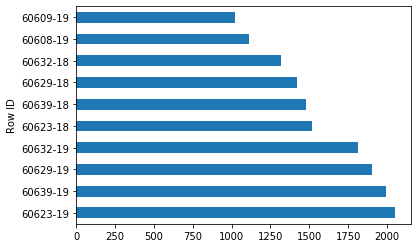

In [58]:
covid_zip_total_cases.plot.barh()

In [59]:
covid["ZIP Code Location"]

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: ZIP Code Location, Length: 600, dtype: object

In [60]:
crs = {'init': 'epsg:4326'}

In [61]:
covid['geometry'] = covid["ZIP Code Location"]

In [62]:
covid.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
0,60604,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153),POINT (-87.62902900000002 41.878153)


In [63]:
covid.geometry

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: geometry, Length: 600, dtype: object

In [64]:
from shapely import wkt

In [65]:
#geo_covid = gpd.GeoDataFrame(covid, crs = crs, geometry = covid.geometry)

In [66]:
covid = covid[covid.geometry != 0]

In [67]:
covid.geometry
#covid['geometry'] = covid['geometry'].apply(wkt.loads)
#gdf = gpd.GeoDataFrame(covid, geometry = 'geometry')

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: geometry, Length: 590, dtype: object

In [68]:
covid['geometry'] = covid['geometry'].apply(wkt.loads)

In [72]:
gdf = gpd.GeoDataFrame(covid, crs = crs, geometry='geometry')


C:\Users\ilang\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [73]:
gdf.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
0,60604,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153),POINT (-87.62903 41.87815)


In [74]:
gdf19 = gdf[gdf['Week Number']==19]
gdf19.head()

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
3,60606,19,5/3/2020,5/9/2020,7,36,303.0,"1,559.80",48,228,...,0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634),POINT (-87.63676 41.88263)
7,60651,19,5/3/2020,5/9/2020,228,1007,355.0,"1,566.90",622,"2,902",...,0.4,0.3,3,40,4.7,62.2,"64,267",60651-19,POINT (-87.741017 41.901964),POINT (-87.74102 41.90196)
10,60624,19,5/3/2020,5/9/2020,85,566,223.0,"1,485.40",327,"1,847",...,0.3,0.3,1,18,2.6,47.2,"38,105",60624-19,POINT (-87.722735 41.879417),POINT (-87.72274 41.87942)
28,60646,19,5/3/2020,5/9/2020,44,257,162.0,945.7,146,"1,252",...,0.3,0.2,14,22,51.5,81.0,"27,177",60646-19,POINT (-87.761826 41.993931),POINT (-87.76183 41.99393)
31,60639,19,5/3/2020,5/9/2020,514,1991,568.0,"2,202.30","1,123","4,711",...,0.5,0.4,17,60,18.8,66.4,"90,407",60639-19,POINT (-87.75531 41.920609),POINT (-87.75531 41.92061)


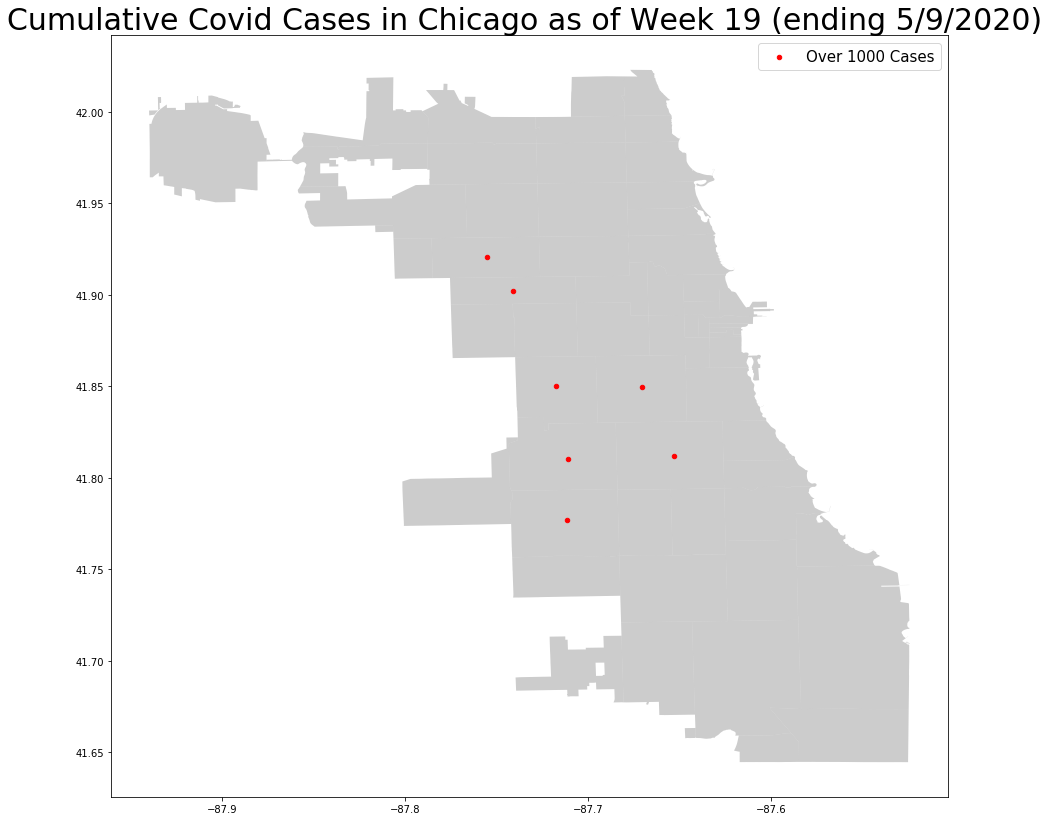

In [77]:
fig, ax = plt.subplots(figsize = (15,15))
zip_map.plot(ax=ax, alpha = 0.4, color = "grey")
#gdf[gdf['Week Number']==19].plot(ax=ax, markersize=20, color = "blue", marker = "o", label="Case")
gdf19[gdf19["Cases - Cumulative"]>=1000].plot(ax=ax, markersize=20, color = "red", marker = "o", label="Over 1000 Cases")
#gdf19[gdf19["Cases - Cumulative"]<1000].plot(ax=ax, markersize=20, color = "blue", marker = "o", label="Under 1000 Cases")
plt.title("Cumulative Covid Cases in Chicago as of Week 19 (ending 5/9/2020) ", fontsize = 30)
plt.legend(prop={'size':15})

In [104]:
#gdf[gdf['Cases - Cumulative']>100]
gdf['Cases - Cumulative'].nlargest()

331    939
513    917
249    900
223    879
301    875
Name: Cases - Cumulative, dtype: int32

In [84]:
gdf.isna()/gdf.columns()

TypeError: 'Index' object is not callable

In [87]:
len(gdf.columns)

22

In [88]:
gdf.is_empty

0      False
1      False
2      False
3      False
4      False
       ...  
595    False
596    False
597    False
598    False
599    False
Length: 590, dtype: bool

In [108]:
covid["Cases - Cumulative"].nlargest()

331    939
513    917
249    900
223    879
301    875
Name: Cases - Cumulative, dtype: int32

In [115]:
covid[covid["Week Number"]==19]

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
3,Unknown,19,5/3/2020,5/9/2020,7,36,303.0,"1,559.80",48,228,...,0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634),POINT (-87.63676 41.88263)
7,Unknown,19,5/3/2020,5/9/2020,228,1,355.0,"1,566.90",622,"2,902",...,0.4,0.3,3,40,4.7,62.2,"64,267",60651-19,POINT (-87.741017 41.901964),POINT (-87.74102 41.90196)
10,Unknown,19,5/3/2020,5/9/2020,85,566,223.0,"1,485.40",327,"1,847",...,0.3,0.3,1,18,2.6,47.2,"38,105",60624-19,POINT (-87.722735 41.879417),POINT (-87.72274 41.87942)
28,Unknown,19,5/3/2020,5/9/2020,44,257,162.0,945.7,146,"1,252",...,0.3,0.2,14,22,51.5,81.0,"27,177",60646-19,POINT (-87.761826 41.993931),POINT (-87.76183 41.99393)
31,Unknown,19,5/3/2020,5/9/2020,514,1,568.0,"2,202.30","1,123","4,711",...,0.5,0.4,17,60,18.8,66.4,"90,407",60639-19,POINT (-87.75531 41.920609),POINT (-87.75531 41.92061)
34,Unknown,19,5/3/2020,5/9/2020,98,678,196.0,"1,352.20",499,"2,176",...,0.2,0.3,19,55,37.9,109.7,"50,139",60626-19,POINT (-87.669834 42.009469),POINT (-87.66983 42.00947)
62,Unknown,19,5/3/2020,5/9/2020,76,586,116.0,890.7,383,"2,215",...,0.2,0.3,15,58,22.8,88.2,"65,790",60640-19,POINT (-87.662232 41.971888),POINT (-87.66223 41.97189)
78,Unknown,19,5/3/2020,5/9/2020,29,278,68.0,650.3,142,"1,088",...,0.2,0.3,7,27,16.4,63.2,"42,752",60660-19,POINT (-87.666362 41.991062),POINT (-87.66636 41.99106)
79,Unknown,19,5/3/2020,5/9/2020,143,744,155.0,808,531,"2,806",...,0.3,0.3,7,25,7.6,27.1,"92,084",60618-19,POINT (-87.703343 41.946699),POINT (-87.70334 41.94670)
89,Unknown,19,5/3/2020,5/9/2020,483,1,424.0,"1,673.20","1,215","4,659",...,0.4,0.4,7,37,6.1,32.5,"113,916",60629-19,POINT (-87.711565 41.777061),POINT (-87.71156 41.77706)


In [112]:
covid["ZIP Code"]

0      Unknown
1      Unknown
2      Unknown
3      Unknown
4      Unknown
        ...   
595    Unknown
596    Unknown
597    Unknown
598    Unknown
599    Unknown
Name: ZIP Code, Length: 590, dtype: object

In [113]:
covid

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
0,Unknown,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153),POINT (-87.62903 41.87815)
1,Unknown,11,3/8/2020,3/14/2020,0,0,0.0,0,3,3,...,0.0,0.0,0,0,0.0,0.0,"35,912",60621-11,POINT (-87.638812 41.776931),POINT (-87.63881 41.77693)
2,Unknown,11,3/8/2020,3/14/2020,0,0,0.0,0,5,6,...,0.0,0.0,0,0,0.0,0.0,"50,139",60626-11,POINT (-87.669834 42.009469),POINT (-87.66983 42.00947)
3,Unknown,19,5/3/2020,5/9/2020,7,36,303.0,"1,559.80",48,228,...,0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634),POINT (-87.63676 41.88263)
4,Unknown,15,4/5/2020,4/11/2020,81,148,147.0,269,232,648,...,0.3,0.2,2,3,3.6,5.5,"55,026",60638-15,POINT (-87.771902 41.787032),POINT (-87.77190 41.78703)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Unknown,16,4/12/2020,4/18/2020,61,232,204.0,775.7,199,722,...,0.3,0.3,2,13,6.7,43.5,"29,908",60653-16,POINT (-87.611244 41.819261),POINT (-87.61124 41.81926)
596,Unknown,14,3/29/2020,4/4/2020,33,71,38.0,81.3,176,478,...,0.2,0.1,1,1,1.1,1.1,"87,291",60647-14,POINT (-87.701101 41.921058),POINT (-87.70110 41.92106)
597,Unknown,14,3/29/2020,4/4/2020,39,67,71.0,121.8,206,416,...,0.2,0.2,1,1,1.8,1.8,"55,026",60638-14,POINT (-87.771902 41.787032),POINT (-87.77190 41.78703)
598,Unknown,12,3/15/2020,3/21/2020,9,9,10.0,9.8,74,81,...,0.1,0.1,0,0,0.0,0.0,"92,108",60623-12,POINT (-87.717446 41.850321),POINT (-87.71745 41.85032)
